### Initialization

In [1]:
from pathlib import Path
import open3d as o3d
import os
import sys
from pathlib import Path

# Add the parent directory to sys.path so 'src' can be imported
sys.path.append(str(Path.cwd().parent))

from pytorch_lightning import seed_everything

from src.dataset_utils import (
    get_singleview_data_trt,
    get_singleview_data,
    get_multiview_data,
    get_voxel_data_json,
    get_image_transform_latent_model,
    get_pointcloud_data,
    get_mv_dm_data,
    get_sv_dm_data,
    get_sketch_data
)
from src.model_utils import Model
from src.mvdream_utils import load_mvdream_model
import argparse
from PIL import Image


from comet_ml import start
from comet_ml.integration.pytorch import log_model
from comet_ml.api import API

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import time

import Optim_Utils
from Optim_Utils import Optim_Visualizations
import torch

import boto3
import psutil


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/rayhub-user/.conda/envs/wala/lib/python3.10/site-packages/spconv/pytorch/functional.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  _TORCH_CUSTOM_FWD = amp.custom_fwd(cast_inputs=torch.float16)
/home/rayhub-user/.conda/envs/wala/lib/python3.10/site-packages/spconv/pytorch/functional.py:97: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/rayhub-user/.conda/envs/wala/lib/python3.10/site-packages/spconv/pytorch/functional.py:163: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/rayhub-user/.conda/envs/wala/lib/python3.10/site-packages/spconv/pytorch/functional.py:243: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprec

In [2]:

def simplify_mesh(obj_path, target_num_faces=1000):
    mesh = o3d.io.read_triangle_mesh(obj_path)
    simplified_mesh = mesh.simplify_quadric_decimation(target_num_faces)
    o3d.io.write_triangle_mesh(obj_path, simplified_mesh)


def generate_3d_object(
    model,
    data,
    data_idx,
    scale,
    diffusion_rescale_timestep,
    experiment,
    save_dir="examples",
    output_format="obj",
    target_num_faces=None,
    seed=42,
    
):
    # Set seed
    seed_everything(seed, workers=True)

    model.set_inference_fusion_params(scale, diffusion_rescale_timestep)
    low, high = model.forward(
        data, data_idx, experiment,  output_format=output_format
    )

    return low,high    

In [5]:
os.environ["XFORMERS_DISABLED"] = "1"



model_name = 'ADSKAILab/WaLa-SV-1B'
images_path = Path('../examples/single_view/')
single_image = ['../examples/single_view/table.png']

output_dir = 'examples/Test_Gen'
output_format = 'obj'
target_num_faces = None
scale = 1.8
seed = 42
diffusion_rescale_timestep = 5

print(f"Loading model")


model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()
model.set_inference_fusion_params(
        scale, diffusion_rescale_timestep
    )
experiment = None

Loading model


/home/rayhub-user/.conda/envs/wala/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.0


'DotDict' object has no attribute 'dataset_path'
'DotDict' object has no attribute 'low_avg'
'DotDict' object has no attribute 'low_avg'
Low avg used : None high value: 63


Using cache found in /home/rayhub-user/.cache/torch/hub/facebookresearch_dinov2_main


cond_emb_dim: 1024
Input resolution: 224
Vocab size: N/A
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
3
bior6.8
constant
256


### Test 1 - 3 images

In [6]:
def run_inference(image_path,save_dir,model,experiment= None):
    lh_dic = {}
    for idx, image_path in enumerate(image_path.iterdir()):  # Enumerate to get the index
        timer1 = time.time()
        print(f"Processing image: {image_path}")
        data = get_singleview_data(
            image_file=Path(image_path),
            image_transform=image_transform,
            device=model.device,
            image_over_white=False,
        )
        data_idx = 0
        save_dir = Path(output_dir) 
        base_name = os.path.basename(image_path)
        image_name = os.path.splitext(base_name)[0]  
        model.set_inference_fusion_params(
            scale, diffusion_rescale_timestep
        )
        low, high = generate_3d_object(
            model,
            data,
            data_idx,
            scale,
            diffusion_rescale_timestep,
            experiment,
            output_format,
            target_num_faces,
            seed,
        )
        delta = time.time() - timer1
        print('Total Inference time', delta)

        try:
            delta = time.time() - timer1
            experiment.log_metric("Default Delta", delta)
            print('Total Inference time', delta)
        except:
            pass
        
        lh_dic[image_name] = (low,high)

    return lh_dic
lh_dic = run_inference(images_path,output_dir,model)


Seed set to 42


Processing image: ../examples/single_view/pitcher.png


Extract Image 0.6761248111724854 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.577455759048462 s
Latent Decoding Time 0.13740134239196777 s
Wavelet Preparation Time 6.437301635742188e-05 s
Low to Highs conversion 0.030336380004882812 s
Total Inference time 3.4544520378112793
Processing image: ../examples/single_view/table.png
Extract Image 0.013089656829833984 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.346694231033325 s
Latent Decoding Time 0.004123687744140625 s
Wavelet Preparation Time 4.100799560546875e-05 s
Low to Highs conversion 0.02658224105834961 s
Total Inference time 2.4023549556732178
Processing image: ../examples/single_view/apple.jpeg
Extract Image 0.013315916061401367 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3470826148986816 s
Latent Decoding Time 0.004157066345214844 s
Wavelet Preparation Time 4.267692565917969e-05 s
Low to Highs conversion 0.026785612106323242 s
Total Inference time 2.4103848934173584
Processing image: ../examples/single_view/pear.jpeg
Extract Image 0.013404369354248047 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3498034477233887 s
Latent Decoding Time 0.004083156585693359 s
Wavelet Preparation Time 4.38690185546875e-05 s
Low to Highs conversion 0.026808738708496094 s
Total Inference time 2.413193941116333
Processing image: ../examples/single_view/chair.png
Extract Image 0.01308131217956543 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3409652709960938 s
Latent Decoding Time 0.004231452941894531 s
Wavelet Preparation Time 4.792213439941406e-05 s
Low to Highs conversion 0.0270082950592041 s
Total Inference time 2.4051108360290527


## Dataset Extraction and Utilization for Benchmarking

#### Utils

In [18]:
source_folder = os.path.expanduser('/Google_Dataset_Outputs/5.1')
check_folder = Path("/home/rayhub-user/Optim-WaLa/Benchmark_quality/Original")
destination_folder = Path("/home/rayhub-user/Optim-WaLa/Benchmark_quality/Tensor_RT_5.1")

Optim_Utils.find_and_move_matching_files(source_folder, check_folder, destination_folder, TRT = True)


[DEBUG] Files in check_folder (/home/rayhub-user/Optim-WaLa/Benchmark_quality/Original): 20 found
[DEBUG] Files in source_folder (/Google_Dataset_Outputs/5.1): 1030 found
Moved: 2_of_Jenga_Classic_Game_trt.obj from /Google_Dataset_Outputs/5.1 to /home/rayhub-user/Optim-WaLa/Benchmark_quality/Tensor_RT_5.1
Moved: 50_BLOCKS_trt.obj from /Google_Dataset_Outputs/5.1 to /home/rayhub-user/Optim-WaLa/Benchmark_quality/Tensor_RT_5.1
Moved: 5_HTP_trt.obj from /Google_Dataset_Outputs/5.1 to /home/rayhub-user/Optim-WaLa/Benchmark_quality/Tensor_RT_5.1
[DEBUG] No match for: ASICS_GELAce_Pro_Pearl_WhitePink_trt.obj (match_name: ASICS_GELAce_Pro_Pearl_WhitePink.obj)
[DEBUG] No match for: ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange_trt.obj (match_name: ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.obj)
[DEBUG] No match for: Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3_trt.obj (match_name: Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.obj)
[DEBUG] No match for: Asus_M5A99FX_PRO_R20_Motherbo

In [28]:
source_folder = os.path.expanduser('/Google_Dataset_Outputs')
check_folder = Path("/home/rayhub-user/Optim-WaLa/Benchmark_quality/Original")
destination_folder = Path("/home/rayhub-user/Optim-WaLa/Benchmark_quality/Tensor_RT")

# Check the contents of each folder
Optim_Utils.check_folder_contents(source_folder)
Optim_Utils.check_folder_contents(check_folder)
Optim_Utils.check_folder_contents(destination_folder)

Contents of /Google_Dataset_Outputs:
- 10.1
- 15.1
- 5.1
Contents of /home/rayhub-user/Optim-WaLa/Benchmark_quality/Original:
- 3D_Dollhouse_Refrigerator.obj
- 60_CONSTRUCTION_SET.obj
- 3M_Antislip_Surfacing_Light_Duty_White.obj
- ALPHABET_AZ_GRADIENT.obj
- 3D_Dollhouse_Sink.obj
- 3D_Dollhouse_Lamp.obj
- 5_HTP.obj
- 2_of_Jenga_Classic_Game.obj
- 3D_Dollhouse_Swing.obj
- 30_CONSTRUCTION_SET.obj
- 3D_Dollhouse_Happy_Brother.obj
- 3M_Vinyl_Tape_Green_1_x_36_yd.obj
- ALPHABET_AZ_GRADIENT_WQb1ufEycSj.obj
- ACE_Coffee_Mug_Kristen_16_oz_cup.obj
- 50_BLOCKS.obj
- 3D_Dollhouse_Sofa.obj
- 11pro_SL_TRX_FG.obj
- 45oz_RAMEKIN_ASST_DEEP_COLORS.obj
- 3D_Dollhouse_TablePurple.obj
- AMBERLIGHT_UP_W.obj
Contents of /home/rayhub-user/Optim-WaLa/Benchmark_quality/Tensor_RT:
- 3D_Dollhouse_Lamp_trt.obj
- 3D_Dollhouse_Sink_trt.obj
- 3D_Dollhouse_Sofa_trt.obj
- 3M_Vinyl_Tape_Green_1_x_36_yd_trt.obj
- ACE_Coffee_Mug_Kristen_16_oz_cup_trt.obj
- 30_CONSTRUCTION_SET_trt.obj
- 2_of_Jenga_Classic_Game_trt.obj
- AM

In [49]:
import zipfile
import os

def unzip_all_in_dir(source_dir='.', target_dir='./unzipped'):
    os.makedirs(target_dir, exist_ok=True)
    for filename in os.listdir(source_dir):
        if filename.endswith('.zip'):
            zip_path = os.path.join(source_dir, filename)
            extract_dir = os.path.join(target_dir, filename[:-4])
            os.makedirs(extract_dir, exist_ok=True)
            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_dir)
                print(f"Extracted {filename} to {extract_dir}")
            except zipfile.BadZipFile:
                print(f"Error: {filename} is not a valid zip file.")

# Example usage:
unzip_all_in_dir('/GD_models', '/GD_Unzipped')

Extracted 2_of_Jenga_Classic_Game.zip to /GD_Unzipped/2_of_Jenga_Classic_Game
Extracted 50_BLOCKS.zip to /GD_Unzipped/50_BLOCKS
Extracted 5_HTP.zip to /GD_Unzipped/5_HTP
Extracted ASICS_GELAce_Pro_Pearl_WhitePink.zip to /GD_Unzipped/ASICS_GELAce_Pro_Pearl_WhitePink
Extracted ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.zip to /GD_Unzipped/ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange
Extracted Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.zip to /GD_Unzipped/Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3
Extracted Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3.zip to /GD_Unzipped/Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3
Extracted Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3.zip to /GD_Unzipped/Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3
Extracted Asus_Sabertooth_Z97_MARK_1_Motherboard_ATX_LGA1150_Socket.zip to /GD_Unzipped/Asus_Sabertooth_Z97_MARK_1_Motherboard_ATX_LGA1150_Socket
Extracted BlackBlack_Nintendo_3DSXL.zip to /GD_Unzipped/BlackBlack_Nintendo_

In [50]:
import os
import shutil

def extract_and_rename(thumbnail_dir, unzipped_dir, dest_dir):
    # Ensure destination directory exists
    os.makedirs(dest_dir, exist_ok=True)

    # Get thumbnail base names (without extension)
    thumbnails = [os.path.splitext(f)[0] for f in os.listdir(thumbnail_dir) if os.path.isfile(os.path.join(thumbnail_dir, f))]

    # Get folder names in unzipped_dir
    folders = [f for f in os.listdir(unzipped_dir) if os.path.isdir(os.path.join(unzipped_dir, f))]

    for folder in folders:
        if folder in thumbnails:
            # Find the original thumbnail file
            thumb_files = [f for f in os.listdir(thumbnail_dir) if os.path.splitext(f)[0] == folder]
            if not thumb_files:
                continue
            thumbnail_file = thumb_files[0]
            # Source model.obj path
            model_path = os.path.join(unzipped_dir, folder, 'meshes', 'model.obj')
            if os.path.exists(model_path):
                # New name: folder name + original thumbnail name (without extension)
                new_name = f"{folder}.obj"
                dest_path = os.path.join(dest_dir, new_name)
                shutil.copy2(model_path, dest_path)
                print(f"Copied {model_path} to {dest_path}")
            else:
                print(f"model.obj not found in {folder}/meshes/")

extract_and_rename('/GD_Dataset_Single_View', '/GD_Unzipped', '/GD_Objects')

Copied /GD_Unzipped/2_of_Jenga_Classic_Game/meshes/model.obj to /GD_Objects/2_of_Jenga_Classic_Game.obj
Copied /GD_Unzipped/50_BLOCKS/meshes/model.obj to /GD_Objects/50_BLOCKS.obj
Copied /GD_Unzipped/5_HTP/meshes/model.obj to /GD_Objects/5_HTP.obj
Copied /GD_Unzipped/ASICS_GELAce_Pro_Pearl_WhitePink/meshes/model.obj to /GD_Objects/ASICS_GELAce_Pro_Pearl_WhitePink.obj
Copied /GD_Unzipped/ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange/meshes/model.obj to /GD_Objects/ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.obj
Copied /GD_Unzipped/Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3/meshes/model.obj to /GD_Objects/Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.obj
Copied /GD_Unzipped/Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3/meshes/model.obj to /GD_Objects/Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3.obj
Copied /GD_Unzipped/Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3/meshes/model.obj to /GD_Objects/Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3.obj
Copied /GD_Unz

In [69]:
from pathlib import Path

def upload_folder_to_s3(folder_path, bucket_name, s3_prefix=""):
    folder = Path(folder_path)
    file_paths = [f for f in folder.glob("**/*") if f.is_file()]
    s3 = boto3.client('s3')
    for file_path in file_paths:
        # Get the relative path from the folder root
        rel_path = file_path.relative_to(folder)
        s3_key = f"{s3_prefix}/{rel_path}" if s3_prefix else str(rel_path)
        with open(file_path, "rb") as f:
            s3.upload_fileobj(f, bucket_name, s3_key)
        print(f"Uploaded {file_path} to s3://{bucket_name}/{s3_key}")

# Example usage:
upload_folder_to_s3("/GD_Dataset_Single_View", "giuliaa-optim", s3_prefix="/Google_Dataset_Single_View")

Uploaded /GD_Dataset_Single_View/2_of_Jenga_Classic_Game.jpg to s3://giuliaa-optim//Google_Dataset_Single_View/2_of_Jenga_Classic_Game.jpg
Uploaded /GD_Dataset_Single_View/50_BLOCKS.jpg to s3://giuliaa-optim//Google_Dataset_Single_View/50_BLOCKS.jpg
Uploaded /GD_Dataset_Single_View/5_HTP.jpg to s3://giuliaa-optim//Google_Dataset_Single_View/5_HTP.jpg
Uploaded /GD_Dataset_Single_View/ASICS_GELAce_Pro_Pearl_WhitePink.jpg to s3://giuliaa-optim//Google_Dataset_Single_View/ASICS_GELAce_Pro_Pearl_WhitePink.jpg
Uploaded /GD_Dataset_Single_View/ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.jpg to s3://giuliaa-optim//Google_Dataset_Single_View/ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.jpg
Uploaded /GD_Dataset_Single_View/Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.jpg to s3://giuliaa-optim//Google_Dataset_Single_View/Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.jpg
Uploaded /GD_Dataset_Single_View/Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3.jpg to s3://giuliaa-optim//Google_D

### Dataset download and extraction

In [ ]:
zip_dir = '/Google_Dataset'         # Folder with zip files
output_dir = '/Google_Extracted_Dataset/'  # Where to save extracted thumbnails
os.makedirs(output_dir, exist_ok=True)

Optim_Utils.extract_first_thumbnail('/Google_Dataset/Dataset', '/Google_Dataset/Dataset/Single_Images')

In [ ]:
folder1 = "/home/ray/WaLa/Benchmark_quality/Original"
folder2 = "/home/ray/WaLa/Benchmark_quality/Simplified"
Optim_Utils.compare_file_sizes(folder1, folder2)

### Dataset Inference Tests

In [9]:
experiment = start(
  api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ",
  project_name="wala-time-checks",
  workspace="alessandro-giuliano")


  # Define the hyperparameters
hyperparameters = {
    "model_name": "ADSKAILab/WaLa-SV-1B",
    "images_path": str(Path("examples/single_view/")),
    "single_image": ["examples/single_view/table.png"],
    "output_dir": "examples/Test_Gen",
    "output_format": "obj",
    "target_num_faces": None,
    "scale": 1.8,
    "seed": 42,
    "diffusion_rescale_timestep": 5,
    "Mcubes-Optimized": True,
    "Object-3D_simplified_mesh": None,
}

# Log the hyperparameters to Comet
experiment.log_parameters(hyperparameters)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/fb5036f175c24cf7b4b121939cac702c



In [12]:
### Scanned Objects by Google Research
google_test_img_path = Path(os.path.expanduser('/GD_Dataset_Single_View'))  # Expands '~' to the full home directory path
output_dir = os.path.expanduser('/Obj_generated')

model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()

run_inference(google_test_img_path,output_dir,model, experiment)

experiment.end()

'DotDict' object has no attribute 'dataset_path'
'DotDict' object has no attribute 'low_avg'
'DotDict' object has no attribute 'low_avg'
Low avg used : None high value: 63


Using cache found in /home/rayhub-user/.cache/torch/hub/facebookresearch_dinov2_main


cond_emb_dim: 1024
Input resolution: 224
Vocab size: N/A
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
3
bior6.8
constant
256


Seed set to 42


Processing image: /GD_Dataset_Single_View/2_of_Jenga_Classic_Game.jpg
Extract Image 0.013253211975097656 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3398821353912354 s
Latent Decoding Time 0.005384206771850586 s
Wavelet Preparation Time 0.00014853477478027344 s
Low to Highs conversion 0.026609182357788086 s
Total Inference time 2.396352767944336
Total Inference time 2.396418809890747
Processing image: /GD_Dataset_Single_View/50_BLOCKS.jpg
Extract Image 0.01309347152709961 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3482916355133057 s
Latent Decoding Time 0.004361152648925781 s
Wavelet Preparation Time 0.00015020370483398438 s
Low to Highs conversion 0.02671957015991211 s
Total Inference time 2.411620855331421
Total Inference time 2.411684274673462
Processing image: /GD_Dataset_Single_View/5_HTP.jpg
Extract Image 0.013231515884399414 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3494229316711426 s
Latent Decoding Time 0.004312753677368164 s
Wavelet Preparation Time 0.00015974044799804688 s
Low to Highs conversion 0.026659727096557617 s
Total Inference time 2.4132845401763916
Total Inference time 2.4133472442626953
Processing image: /GD_Dataset_Single_View/ASICS_GELAce_Pro_Pearl_WhitePink.jpg
Extract Image 0.013263225555419922 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3514740467071533 s
Latent Decoding Time 0.004320621490478516 s
Wavelet Preparation Time 0.00014328956604003906 s
Low to Highs conversion 0.026795625686645508 s
Total Inference time 2.415597915649414
Total Inference time 2.415661096572876
Processing image: /GD_Dataset_Single_View/ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.jpg
Extract Image 0.013157367706298828 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.339170455932617 s
Latent Decoding Time 0.0043125152587890625 s
Wavelet Preparation Time 0.0001423358917236328 s
Low to Highs conversion 0.026451587677001953 s
Total Inference time 2.4029953479766846
Total Inference time 2.40305757522583
Processing image: /GD_Dataset_Single_View/Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.jpg
Extract Image 0.013191699981689453 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3358259201049805 s
Latent Decoding Time 0.004387378692626953 s
Wavelet Preparation Time 0.00014328956604003906 s
Low to Highs conversion 0.026499509811401367 s
Total Inference time 2.3998308181762695
Total Inference time 2.3998937606811523
Processing image: /GD_Dataset_Single_View/Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3.jpg
Extract Image 0.013310432434082031 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3396217823028564 s
Latent Decoding Time 0.004691600799560547 s
Wavelet Preparation Time 0.0001666545867919922 s
Low to Highs conversion 0.02653193473815918 s
Total Inference time 2.4040682315826416
Total Inference time 2.4041318893432617
Processing image: /GD_Dataset_Single_View/Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3.jpg
Extract Image 0.013342618942260742 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3416950702667236 s
Latent Decoding Time 0.004317283630371094 s
Wavelet Preparation Time 0.00014448165893554688 s
Low to Highs conversion 0.026539087295532227 s
Total Inference time 2.4056451320648193
Total Inference time 2.4057085514068604
Processing image: /GD_Dataset_Single_View/Asus_Sabertooth_Z97_MARK_1_Motherboard_ATX_LGA1150_Socket.jpg
Extract Image 0.013241291046142578 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.341578722000122 s
Latent Decoding Time 0.004301309585571289 s
Wavelet Preparation Time 0.000164031982421875 s
Low to Highs conversion 0.026486873626708984 s
Total Inference time 2.4057703018188477
Total Inference time 2.4058332443237305
Processing image: /GD_Dataset_Single_View/BlackBlack_Nintendo_3DSXL.jpg
Extract Image 0.013296365737915039 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3433868885040283 s
Latent Decoding Time 0.004480600357055664 s
Wavelet Preparation Time 0.00014495849609375 s
Low to Highs conversion 0.026641368865966797 s
Total Inference time 2.4076974391937256
Total Inference time 2.407759666442871
Processing image: /GD_Dataset_Single_View/Black_Decker_Stainless_Steel_Toaster_4_Slice.jpg
Extract Image 0.013368368148803711 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.343613386154175 s
Latent Decoding Time 0.0045244693756103516 s
Wavelet Preparation Time 0.0001678466796875 s
Low to Highs conversion 0.02678847312927246 s
Total Inference time 2.4083809852600098
Total Inference time 2.4084463119506836
Processing image: /GD_Dataset_Single_View/Black_Elderberry_Syrup_54_oz_Gaia_Herbs.jpg
Extract Image 0.013158559799194336 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3451383113861084 s
Latent Decoding Time 0.00427556037902832 s
Wavelet Preparation Time 0.00016164779663085938 s
Low to Highs conversion 0.02673816680908203 s
Total Inference time 2.4091556072235107
Total Inference time 2.4092180728912354
Processing image: /GD_Dataset_Single_View/BlueBlack_Nintendo_3DSXL.jpg
Extract Image 0.013215780258178711 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3487040996551514 s
Latent Decoding Time 0.003930330276489258 s
Wavelet Preparation Time 0.0001456737518310547 s
Low to Highs conversion 0.02646493911743164 s
Total Inference time 2.412107229232788
Total Inference time 2.412170886993408
Processing image: /GD_Dataset_Single_View/Blue_Jasmine_Includes_Digital_Copy_UltraViolet_DVD.jpg
Extract Image 0.013015270233154297 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3513593673706055 s
Latent Decoding Time 0.004202604293823242 s
Wavelet Preparation Time 0.00014400482177734375 s
Low to Highs conversion 0.026941299438476562 s
Total Inference time 2.4146859645843506
Total Inference time 2.414747714996338
Processing image: /GD_Dataset_Single_View/Cootie_Game.jpg
Extract Image 0.013282537460327148 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3518431186676025 s
Latent Decoding Time 0.0045816898345947266 s
Wavelet Preparation Time 0.0001480579376220703 s
Low to Highs conversion 0.026506423950195312 s
Total Inference time 2.415417194366455
Total Inference time 2.4154796600341797
Processing image: /GD_Dataset_Single_View/Dell_Series_9_Color_Ink_Cartridge_MK993_High_Yield.jpg
Extract Image 0.013869524002075195 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3535585403442383 s
Latent Decoding Time 0.004837512969970703 s
Wavelet Preparation Time 0.00017309188842773438 s
Low to Highs conversion 0.026612043380737305 s
Total Inference time 2.41802716255188
Total Inference time 2.4180898666381836
Processing image: /GD_Dataset_Single_View/Frozen_Scrabble_Jr.jpg
Extract Image 0.01548147201538086 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3545703887939453 s
Latent Decoding Time 0.004751920700073242 s
Wavelet Preparation Time 0.00015997886657714844 s
Low to Highs conversion 0.02655649185180664 s
Total Inference time 2.420931577682495
Total Inference time 2.4209916591644287
Processing image: /GD_Dataset_Single_View/Google_Cardboard_Original_package.jpg
Extract Image 0.014022350311279297 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3567116260528564 s
Latent Decoding Time 0.004463911056518555 s
Wavelet Preparation Time 0.00014352798461914062 s
Low to Highs conversion 0.026935338973999023 s
Total Inference time 2.4213478565216064
Total Inference time 2.421409845352173
Processing image: /GD_Dataset_Single_View/HP_Card_Invitation_Kit.jpg
Extract Image 0.013756275177001953 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3518049716949463 s
Latent Decoding Time 0.004485607147216797 s
Wavelet Preparation Time 0.00014472007751464844 s
Low to Highs conversion 0.026422739028930664 s
Total Inference time 2.415743350982666
Total Inference time 2.415804862976074
Processing image: /GD_Dataset_Single_View/Hyaluronic_Acid.jpg
Extract Image 0.013684511184692383 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.352602243423462 s
Latent Decoding Time 0.00432896614074707 s
Wavelet Preparation Time 0.00014138221740722656 s
Low to Highs conversion 0.0267336368560791 s
Total Inference time 2.416611909866333
Total Inference time 2.416672945022583
Processing image: /GD_Dataset_Single_View/LEGO_Creationary_Game.jpg
Extract Image 0.013557910919189453 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.355164051055908 s
Latent Decoding Time 0.004392385482788086 s
Wavelet Preparation Time 0.00016236305236816406 s
Low to Highs conversion 0.026819467544555664 s
Total Inference time 2.4191842079162598
Total Inference time 2.4192471504211426
Processing image: /GD_Dataset_Single_View/LEGO_Creationary_Game_ZJa163wlWp2.jpg
Extract Image 0.013660430908203125 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.354933738708496 s
Latent Decoding Time 0.004515171051025391 s
Wavelet Preparation Time 0.0001418590545654297 s
Low to Highs conversion 0.02680826187133789 s
Total Inference time 2.419283390045166
Total Inference time 2.419346809387207
Processing image: /GD_Dataset_Single_View/Lenovo_Yoga_2_11.jpg
Extract Image 0.013946771621704102 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.354410171508789 s
Latent Decoding Time 0.0044863224029541016 s
Wavelet Preparation Time 0.000141143798828125 s
Low to Highs conversion 0.02664470672607422 s
Total Inference time 2.419346332550049
Total Inference time 2.419407367706299
Processing image: /GD_Dataset_Single_View/Logitech_Ultimate_Ears_Boom_Wireless_Speaker_Night_Black.jpg
Extract Image 0.013339996337890625 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3572797775268555 s
Latent Decoding Time 0.004670143127441406 s
Wavelet Preparation Time 0.00013828277587890625 s
Low to Highs conversion 0.026610851287841797 s
Total Inference time 2.421807289123535
Total Inference time 2.4218673706054688
Processing image: /GD_Dataset_Single_View/Lovestruck_Tieks_Glittery_Rose_Gold_Italian_Leather_Ballet_Flats.jpg
Extract Image 0.014596939086914062 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3578271865844727 s
Latent Decoding Time 0.004330158233642578 s
Wavelet Preparation Time 0.00013899803161621094 s
Low to Highs conversion 0.02672719955444336 s
Total Inference time 2.4236509799957275
Total Inference time 2.4237143993377686
Processing image: /GD_Dataset_Single_View/Luigis_Mansion_Dark_Moon_Nintendo_3DS_Game.jpg
Extract Image 0.013891458511352539 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.355719804763794 s
Latent Decoding Time 0.004456281661987305 s
Wavelet Preparation Time 0.00015115737915039062 s
Low to Highs conversion 0.02661299705505371 s
Total Inference time 2.420318841934204
Total Inference time 2.4203813076019287
Processing image: /GD_Dataset_Single_View/Mens_ASV_Billfish_Boat_Shoe_in_Dark_Brown_Leather_zdHVHXueI3w.jpg
Extract Image 0.013211488723754883 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3559517860412598 s
Latent Decoding Time 0.004410743713378906 s
Wavelet Preparation Time 0.0001480579376220703 s
Low to Highs conversion 0.026746511459350586 s
Total Inference time 2.4198081493377686
Total Inference time 2.419870376586914
Processing image: /GD_Dataset_Single_View/Mens_Authentic_Original_Boat_Shoe_in_Navy_Leather_xgoEcZtRNmH.jpg
Extract Image 0.013217449188232422 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3578453063964844 s
Latent Decoding Time 0.0044519901275634766 s
Wavelet Preparation Time 0.00014448165893554688 s
Low to Highs conversion 0.026458740234375 s
Total Inference time 2.42091703414917
Total Inference time 2.42097806930542
Processing image: /GD_Dataset_Single_View/Mens_Striper_Sneaker_in_White_rnp8HUli59Y.jpg
Extract Image 0.014529705047607422 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.358398675918579 s
Latent Decoding Time 0.004609584808349609 s
Wavelet Preparation Time 0.00014328956604003906 s
Low to Highs conversion 0.026589155197143555 s
Total Inference time 2.4234228134155273
Total Inference time 2.4234836101531982
Processing image: /GD_Dataset_Single_View/Womens_Audrey_Slip_On_Boat_Shoe_in_Graphite_Nubuck_xWVkCJ5vxZe.jpg
Extract Image 0.013145923614501953 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.357896327972412 s
Latent Decoding Time 0.004454851150512695 s
Wavelet Preparation Time 0.00013971328735351562 s
Low to Highs conversion 0.026782512664794922 s
Total Inference time 2.4216203689575195
Total Inference time 2.4216806888580322
Processing image: /GD_Dataset_Single_View/Womens_Betty_Chukka_Boot_in_Grey_Jersey_Sequin.jpg
Extract Image 0.013373136520385742 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3578481674194336 s
Latent Decoding Time 0.0041849613189697266 s
Wavelet Preparation Time 0.00013494491577148438 s
Low to Highs conversion 0.026752471923828125 s
Total Inference time 2.421396493911743
Total Inference time 2.4214587211608887
Processing image: /GD_Dataset_Single_View/Womens_Betty_Chukka_Boot_in_Salt_Washed_Red_AL2YrOt9CRy.jpg
Extract Image 0.013165712356567383 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3555989265441895 s
Latent Decoding Time 0.00419306755065918 s
Wavelet Preparation Time 0.00013899803161621094 s
Low to Highs conversion 0.0267181396484375 s
Total Inference time 2.4186995029449463
Total Inference time 2.418759822845459
Processing image: /GD_Dataset_Single_View/Womens_Bluefish_2Eye_Boat_Shoe_in_White_Tumbled_YG44xIePRHw.jpg
Extract Image 0.013202428817749023 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3559911251068115 s
Latent Decoding Time 0.004169464111328125 s
Wavelet Preparation Time 0.00014019012451171875 s
Low to Highs conversion 0.026754379272460938 s
Total Inference time 2.4192426204681396
Total Inference time 2.4193027019500732
Processing image: /GD_Dataset_Single_View/30_CONSTRUCTION_SET.jpg
Extract Image 0.013184785842895508 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.354715585708618 s
Latent Decoding Time 0.0042879581451416016 s
Wavelet Preparation Time 0.0001456737518310547 s
Low to Highs conversion 0.026790618896484375 s
Total Inference time 2.418078660964966
Total Inference time 2.4181413650512695
Processing image: /GD_Dataset_Single_View/3D_Dollhouse_Swing.jpg
Extract Image 0.013274431228637695 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.355605363845825 s
Latent Decoding Time 0.004155874252319336 s
Wavelet Preparation Time 0.0001354217529296875 s
Low to Highs conversion 0.026765108108520508 s
Total Inference time 2.4189794063568115
Total Inference time 2.419053554534912
Processing image: /GD_Dataset_Single_View/3M_Antislip_Surfacing_Light_Duty_White.jpg
Extract Image 0.013297796249389648 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3551578521728516 s
Latent Decoding Time 0.00431060791015625 s
Wavelet Preparation Time 0.0001418590545654297 s
Low to Highs conversion 0.026897430419921875 s
Total Inference time 2.4187722206115723
Total Inference time 2.4188342094421387
Processing image: /GD_Dataset_Single_View/3M_Vinyl_Tape_Green_1_x_36_yd.jpg
Extract Image 0.013214349746704102 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3560609817504883 s
Latent Decoding Time 0.004308223724365234 s
Wavelet Preparation Time 0.00014925003051757812 s
Low to Highs conversion 0.026769638061523438 s
Total Inference time 2.4193124771118164
Total Inference time 2.41937518119812
Processing image: /GD_Dataset_Single_View/Animal_Planet_Foam_2Headed_Dragon.jpg
Extract Image 0.013891220092773438 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3563501834869385 s
Latent Decoding Time 0.00430750846862793 s
Wavelet Preparation Time 0.0001494884490966797 s
Low to Highs conversion 0.026665687561035156 s
Total Inference time 2.42033314704895
Total Inference time 2.4203948974609375
Processing image: /GD_Dataset_Single_View/Avengers_Thor_PLlrpYniaeB.jpg
Extract Image 0.013359785079956055 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3568341732025146 s
Latent Decoding Time 0.004375934600830078 s
Wavelet Preparation Time 0.0001380443572998047 s
Low to Highs conversion 0.026589393615722656 s
Total Inference time 2.420231580734253
Total Inference time 2.4202945232391357
Processing image: /GD_Dataset_Single_View/BEDROOM_CLASSIC.jpg
Extract Image 0.014113187789916992 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.357598066329956 s
Latent Decoding Time 0.006094932556152344 s
Wavelet Preparation Time 0.0002110004425048828 s
Low to Highs conversion 0.026918649673461914 s
Total Inference time 2.4240100383758545
Total Inference time 2.424100160598755
Processing image: /GD_Dataset_Single_View/BIA_Cordon_Bleu_White_Porcelain_Utensil_Holder_900028.jpg
Extract Image 0.018497467041015625 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3567256927490234 s
Latent Decoding Time 0.004515886306762695 s
Wavelet Preparation Time 0.00019979476928710938 s
Low to Highs conversion 0.027413129806518555 s
Total Inference time 2.4275474548339844
Total Inference time 2.427619457244873
Processing image: /GD_Dataset_Single_View/CONE_SORTING.jpg
Extract Image 0.017119646072387695 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.360996961593628 s
Latent Decoding Time 0.004729270935058594 s
Wavelet Preparation Time 0.00014662742614746094 s
Low to Highs conversion 0.02688884735107422 s
Total Inference time 2.4301631450653076
Total Inference time 2.4302468299865723
Processing image: /GD_Dataset_Single_View/Clorox_Premium_Choice_Gloves_SM_1_pair.jpg
Extract Image 0.013817071914672852 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3559415340423584 s
Latent Decoding Time 0.004236936569213867 s
Wavelet Preparation Time 0.00014519691467285156 s
Low to Highs conversion 0.02669358253479004 s
Total Inference time 2.4199063777923584
Total Inference time 2.4199671745300293
Processing image: /GD_Dataset_Single_View/Cole_Hardware_Deep_Bowl_Good_Earth_1075.jpg
Extract Image 0.01318216323852539 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3566300868988037 s
Latent Decoding Time 0.004106044769287109 s
Wavelet Preparation Time 0.0001266002655029297 s
Low to Highs conversion 0.026868343353271484 s
Total Inference time 2.420037031173706
Total Inference time 2.4200966358184814
Processing image: /GD_Dataset_Single_View/Cole_Hardware_Dishtowel_BlueWhite.jpg
Extract Image 0.014062881469726562 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3573973178863525 s
Latent Decoding Time 0.004375934600830078 s
Wavelet Preparation Time 0.00014853477478027344 s
Low to Highs conversion 0.0268096923828125 s
Total Inference time 2.423234701156616
Total Inference time 2.4233152866363525
Processing image: /GD_Dataset_Single_View/Cole_Hardware_Hammer_Black.jpg
Extract Image 0.013288259506225586 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.357707977294922 s
Latent Decoding Time 0.004651069641113281 s
Wavelet Preparation Time 0.00015854835510253906 s
Low to Highs conversion 0.026630878448486328 s
Total Inference time 2.4213998317718506
Total Inference time 2.421461820602417
Processing image: /GD_Dataset_Single_View/Cole_Hardware_Mini_Honey_Dipper.jpg
Extract Image 0.01396799087524414 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.358346700668335 s
Latent Decoding Time 0.004317045211791992 s
Wavelet Preparation Time 0.00014066696166992188 s
Low to Highs conversion 0.02672886848449707 s
Total Inference time 2.4223971366882324
Total Inference time 2.4224607944488525
Processing image: /GD_Dataset_Single_View/Cole_Hardware_Plant_Saucer_Brown_125.jpg
Extract Image 0.01340627670288086 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3560962677001953 s
Latent Decoding Time 0.00422215461730957 s
Wavelet Preparation Time 0.00013685226440429688 s
Low to Highs conversion 0.02673935890197754 s
Total Inference time 2.4198198318481445
Total Inference time 2.41987943649292
Processing image: /GD_Dataset_Single_View/Deskstar_Desk_Top_Hard_Drive_1_TB.jpg
Extract Image 0.013327836990356445 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.357802629470825 s
Latent Decoding Time 0.004492044448852539 s
Wavelet Preparation Time 0.0001533031463623047 s
Low to Highs conversion 0.026844263076782227 s
Total Inference time 2.421740770339966
Total Inference time 2.4218039512634277
Processing image: /GD_Dataset_Single_View/Cole_Hardware_Saucer_Glazed_6.jpg
Extract Image 0.013472318649291992 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.356759548187256 s
Latent Decoding Time 0.004225969314575195 s
Wavelet Preparation Time 0.00014019012451171875 s
Low to Highs conversion 0.026604413986206055 s
Total Inference time 2.421088218688965
Total Inference time 2.4211502075195312
Processing image: /GD_Dataset_Single_View/Diet_Pepsi_Soda_Cola12_Pack_12_oz_Cans.jpg
Extract Image 0.013191699981689453 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3591082096099854 s
Latent Decoding Time 0.004437685012817383 s
Wavelet Preparation Time 0.00014400482177734375 s
Low to Highs conversion 0.026947736740112305 s
Total Inference time 2.4229485988616943
Total Inference time 2.4230101108551025
Processing image: /GD_Dataset_Single_View/Ecoforms_Cup_B4_SAN.jpg
Extract Image 0.01328897476196289 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.357443332672119 s
Latent Decoding Time 0.004691600799560547 s
Wavelet Preparation Time 0.00014472007751464844 s
Low to Highs conversion 0.026521921157836914 s
Total Inference time 2.421835422515869
Total Inference time 2.4218966960906982
Processing image: /GD_Dataset_Single_View/Ecoforms_Plant_Container_B4_Har.jpg
Extract Image 0.013244152069091797 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.358630895614624 s
Latent Decoding Time 0.0043506622314453125 s
Wavelet Preparation Time 0.00014472007751464844 s
Low to Highs conversion 0.026555776596069336 s
Total Inference time 2.4221956729888916
Total Inference time 2.422257661819458
Processing image: /GD_Dataset_Single_View/Ecoforms_Plant_Container_GP16AMOCHA.jpg
Extract Image 0.013195514678955078 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.355912208557129 s
Latent Decoding Time 0.004377841949462891 s
Wavelet Preparation Time 0.0001418590545654297 s
Low to Highs conversion 0.026679039001464844 s
Total Inference time 2.4194865226745605
Total Inference time 2.4195499420166016
Processing image: /GD_Dataset_Single_View/Ecoforms_Plant_Container_GP16A_Coral.jpg
Extract Image 0.013739585876464844 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3578402996063232 s
Latent Decoding Time 0.004321575164794922 s
Wavelet Preparation Time 0.00014257431030273438 s
Low to Highs conversion 0.02660679817199707 s
Total Inference time 2.4218039512634277
Total Inference time 2.4218661785125732
Processing image: /GD_Dataset_Single_View/Ecoforms_Plant_Container_QP6HARVEST.jpg
Extract Image 0.013139963150024414 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.35742449760437 s
Latent Decoding Time 0.0044193267822265625 s
Wavelet Preparation Time 0.00014281272888183594 s
Low to Highs conversion 0.026953697204589844 s
Total Inference time 2.421415328979492
Total Inference time 2.4214768409729004
Processing image: /GD_Dataset_Single_View/Ecoforms_Plant_Container_URN_NAT.jpg
Extract Image 0.013219833374023438 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 42


Latent Diffusion Time 2.3570189476013184 s
Latent Decoding Time 0.004558086395263672 s
Wavelet Preparation Time 0.0001552104949951172 s
Low to Highs conversion 0.02670145034790039 s
Total Inference time 2.421597957611084
Total Inference time 2.4216604232788086
Processing image: /GD_Dataset_Single_View/Ecoforms_Plant_Container_Urn_55_Mocha.jpg
Extract Image 0.013185977935791016 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Data Visualization

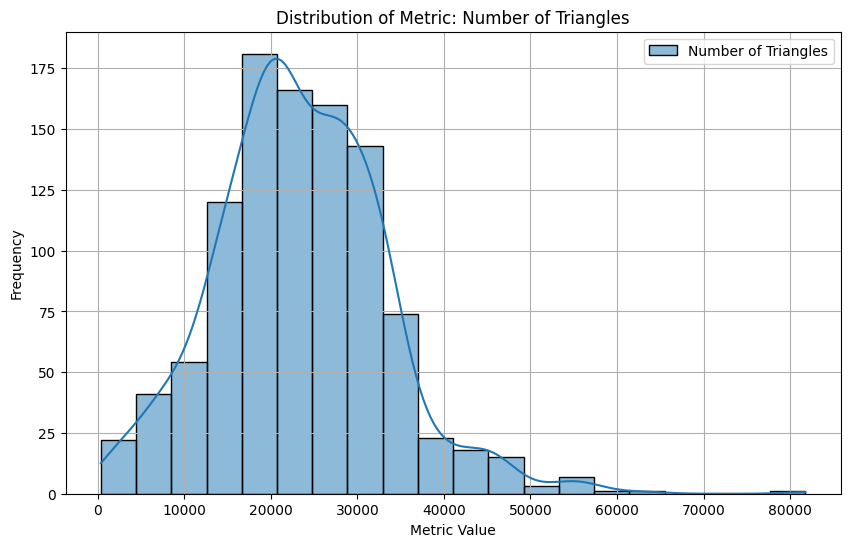

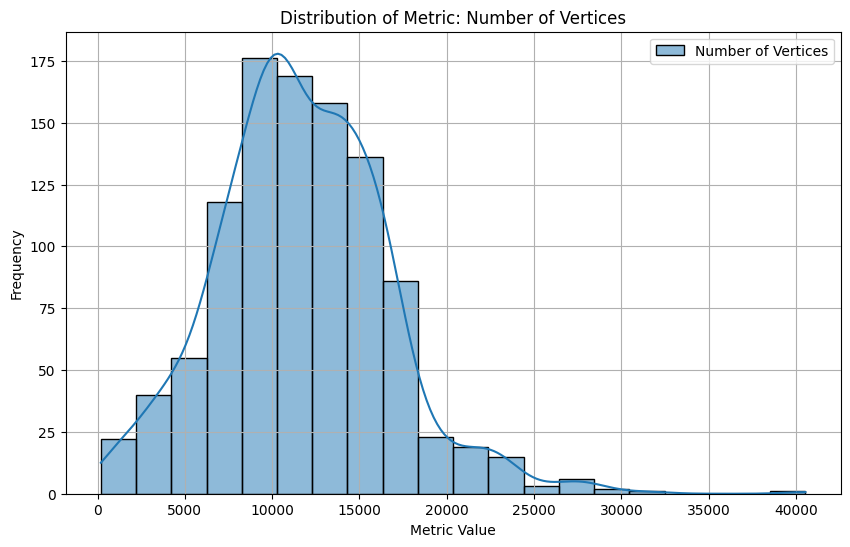

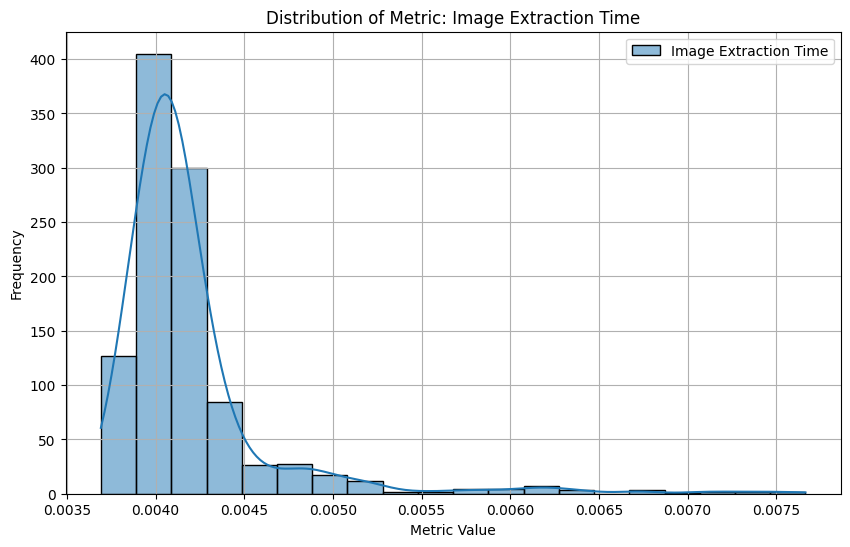

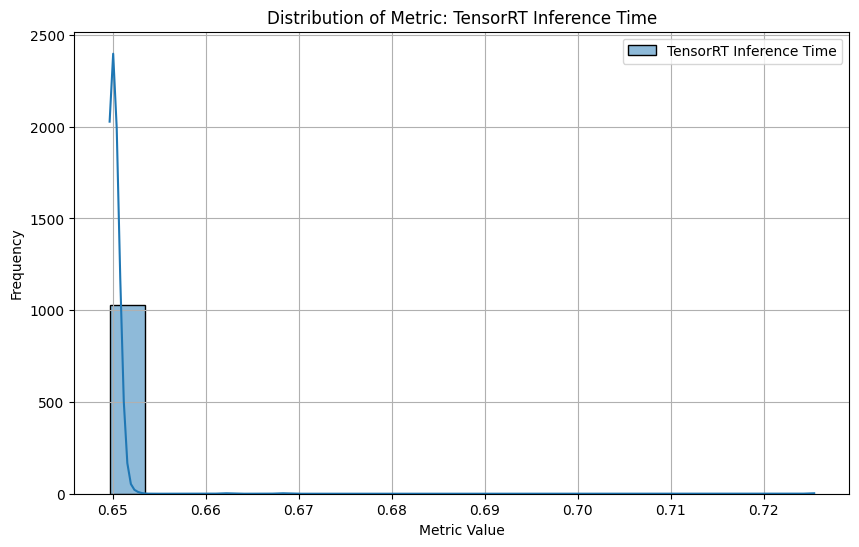

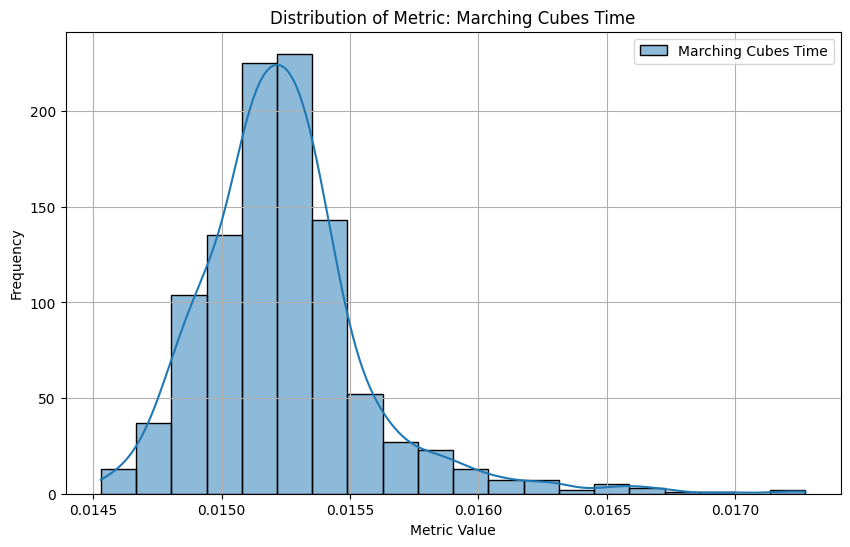

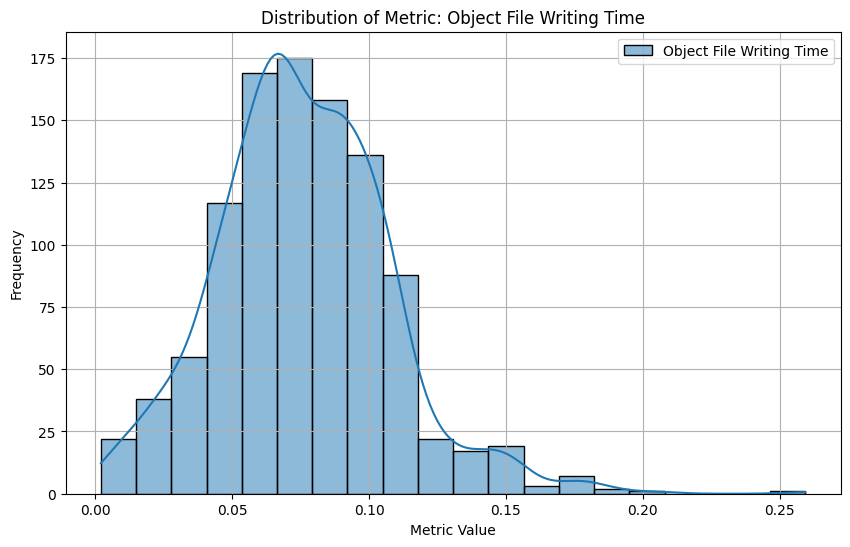

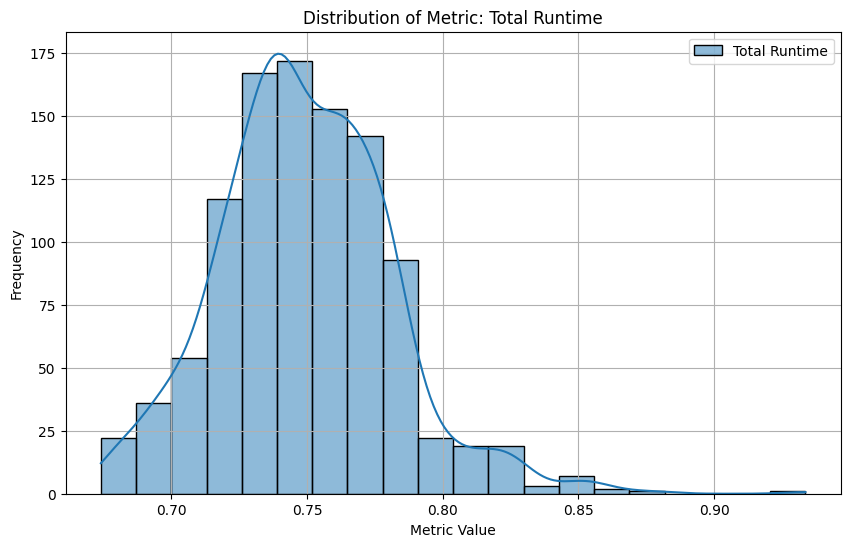

In [12]:
api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ"
comet_api = API(api_key=api_key)
project_name="wala-time-checks"
workspace="alessandro-giuliano"
experiment_key = '1bf42d8c3ee545628968903512893acf'
experiment_keys = {'Benchmark' : '1bf42d8c3ee545628968903512893acf',
                    'mcubes_fast_write' : '223ac82d90fc4292a33c60cc93e9f929',
                    'Simplified Vertex' : '7fa0d3b99b0d48588f11da362ed52aca',
                    'Simplified Quadratic (Inside)' : '86c28056aca843ef9f450d948beb7c61',
                    'Simplified Quadratic (Outside)' : 'ab20f6ca2c98422399ebae16ad717dff',
                    'Tensor_RT_15.1' : '1c8c8f7b0616412c9fea5283877d205c',
                    'Tensor_RT_10.1' : '3406329dd9724231b8c0d9aa6f540e4b',
                    'Tensor_RT_5.1' : '7ecadc0f49c24241863e0188259271db',}
# Retrieve the experiment
experiment = comet_api.get_experiment(workspace, project_name, experiment_keys['Tensor_RT_5.1'])


exp_metric_names = ['Number of Triangles', 
                    'Number of Vertices',
                    'Extract Image',
                    'TensorRT Inference Time',
                    "mcubes.marching_cubes time",
                    "export obj time",
                    'Default Delta']


all_metric_data, metric_names, metric_display_names = Optim_Visualizations.retrieve_and_plot(experiment,exp_metric_names, plotting = True)


In [13]:
sum_metric_names = ["Extract Image",
                    "TensorRT Inference Time",
                    "mcubes.marching_cubes time",
                    "export obj time"]

metric_statistics, default_delta_values = Optim_Visualizations.get_stats(experiment,metric_names, sum_metric_names, display = True)


Metric Statistics:

Number of Triangles:
  Mean: 23465.2583
  Median: 22812.0000
  Min: 364.0000
  Max: 81772.0000
  Sum: 24169216.0000

Number of Vertices:
  Mean: 11722.5864
  Median: 11403.0000
  Min: 190.0000
  Max: 40542.0000
  Sum: 12074264.0000

Extract Image:
  Mean: 0.0042
  Median: 0.0041
  Min: 0.0037
  Max: 0.0077
  Sum: 4.3214

TensorRT Inference Time:
  Mean: 0.6501
  Median: 0.6500
  Min: 0.6496
  Max: 0.7254
  Sum: 669.6495

mcubes.marching_cubes time:
  Mean: 0.0152
  Median: 0.0152
  Min: 0.0145
  Max: 0.0173
  Sum: 15.7009

export obj time:
  Mean: 0.0761
  Median: 0.0735
  Min: 0.0020
  Max: 0.2594
  Sum: 78.3775

Total Sum of Selected Metrics: 768.0494
Default Delta Sum: 771.9181

The total sum of selected metrics is 99.50% of the Default Delta.


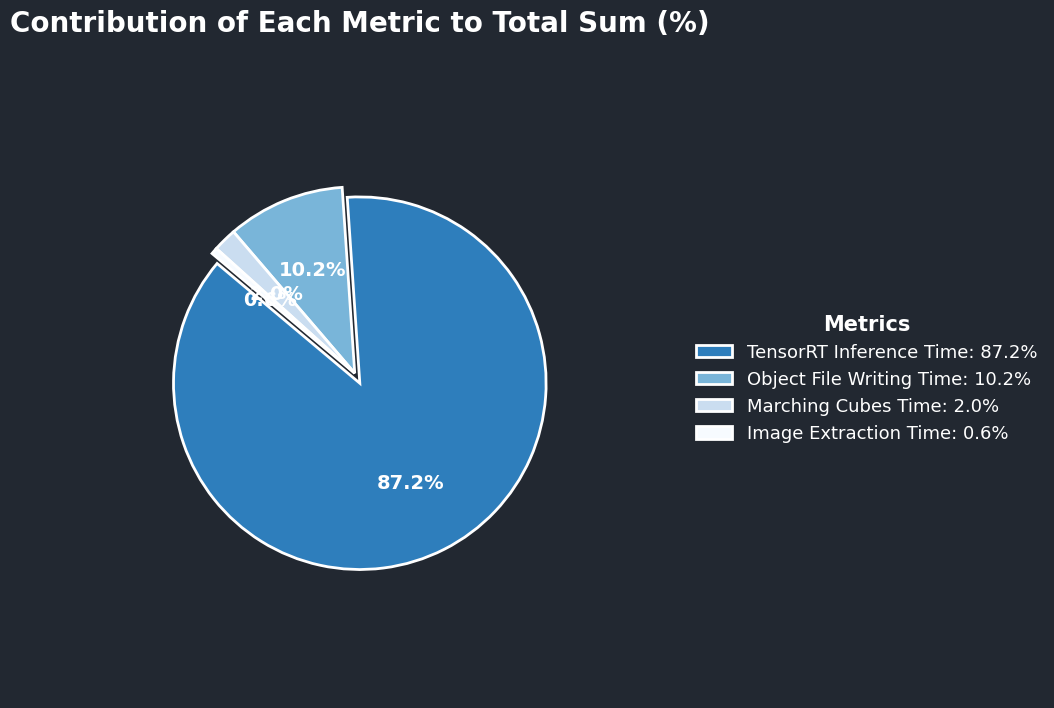

In [14]:
Optim_Visualizations.plot_metric_pie(metric_statistics,metric_display_names,sum_metric_names)

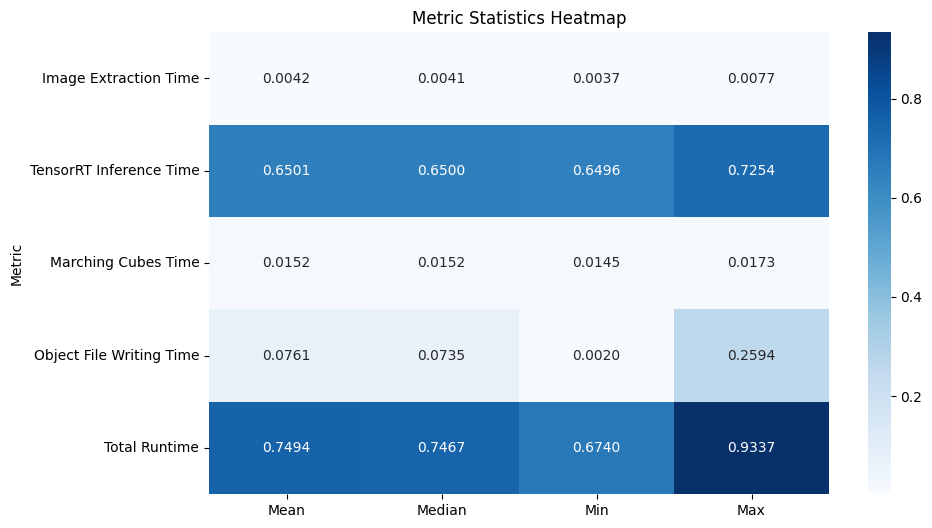

In [17]:
show_triangles = ['Number of Triangles', 'Number of Vertices']

Optim_Visualizations.plot_metric_heatmap(
    metric_statistics,
    metric_display_names,
    default_delta_values,
    show_metric_names = sum_metric_names,
    include_min=True,
    include_max=True,
    include_median=True
)

#### Display Comparisons

WaLa Original: mean = 5.5203, std = 1.1545
WaLa TensorRT 10.1: mean = 1.3874, std = 0.0300


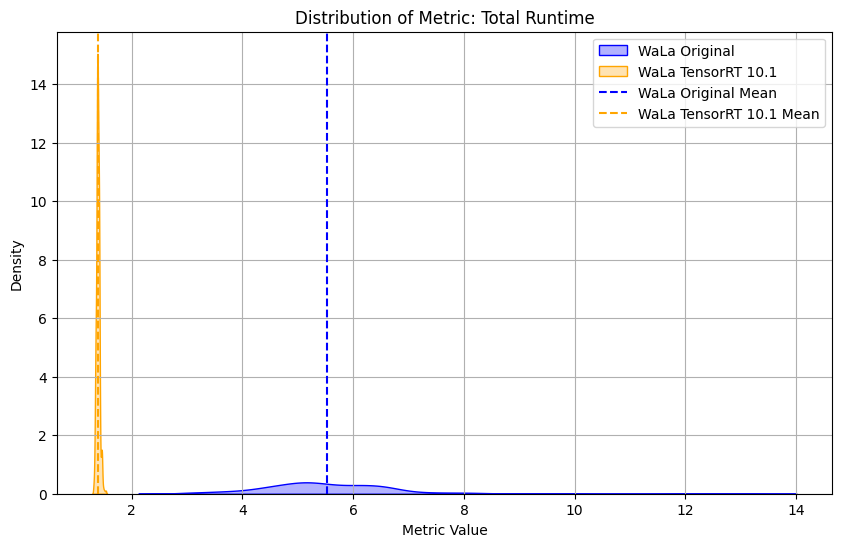

Percentage change in mean: -74.87%
WaLa Original: mean = 5.5203, std = 1.1545
WaLa TensorRT 5.1: mean = 0.7494, std = 0.0322


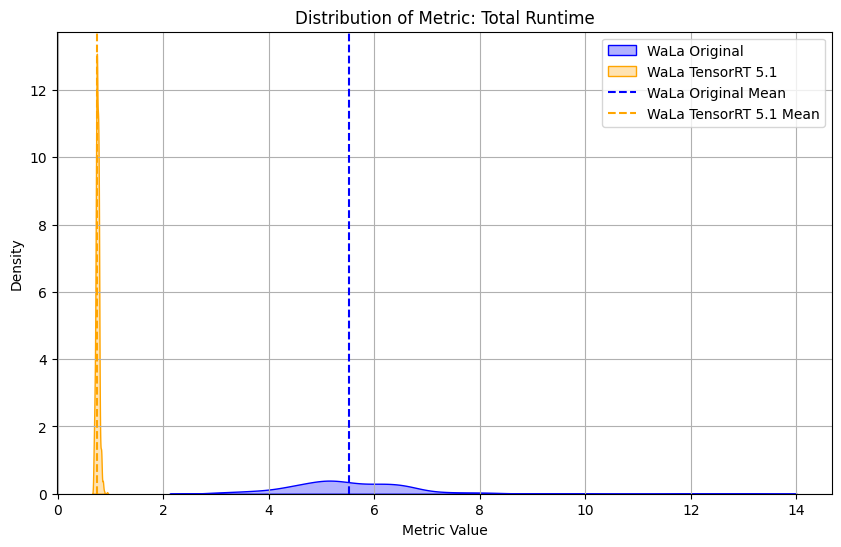

Percentage change in mean: -86.42%


In [27]:

# Retrieve both experiments
experiment1 = comet_api.get_experiment(workspace, project_name, experiment_keys['Benchmark'])
experiment2 = comet_api.get_experiment(workspace, project_name, experiment_keys['Tensor_RT_5.1'])
experiment3 = comet_api.get_experiment(workspace, project_name, experiment_keys['Tensor_RT_10.1'])


# Compare "export obj time"
Optim_Visualizations.compare_metric_distribution(
    experiment1, experiment3, 
    metric_name="Default Delta", 
    label1="WaLa Original", 
    label2="WaLa TensorRT 10.1", 
    display_name="Total Runtime"
)

# Compare "Default Delta" (total runtime)
Optim_Visualizations.compare_metric_distribution(
    experiment1, experiment2, 
    metric_name="Default Delta", 
    label1="WaLa Original", 
    label2="WaLa TensorRT 5.1",
    display_name="Total Runtime"
)



### Custom Optimization Implementations

#### Mcubes object export/ write object to file

In [ ]:

# Generate a large random mesh for testing
num_vertices = 100_000
num_faces = 200_000

vertices = np.random.rand(num_vertices, 3)
triangles = np.random.randint(0, num_vertices, size=(num_faces, 3))


# Test and compare
filename1 = "test_original.obj"
filename2 = "test_optimized.obj"

t1 = Optim_Utils.benchmark_export(Optim_Utils.export_obj_fast, vertices, triangles, filename1)
t2 = Optim_Utils.benchmark_export(Optim_Utils.export_obj_original, vertices, triangles, filename2)

print(f"Original export_obj_original time: {t2:.4f} seconds")
print(f"Optimized export_obj time: {t1:.4f} seconds")
print(f"Speedup: {t2/t1:.2f}x faster")

### Straight Through Visualization with Forward

In [ ]:
from src.diffusion_modules.dwt import DWTInverse3d
import mcubes
args_max_depth = 3
args_wavelet = 'bior6.8'
args_padding_mode = 'constant'
args_resolution = 256


def save_visualization_obj(image_name, obj_path, samples):
        """Save a visualization object."""
        low, highs = samples

        dwt_inverse_3d = DWTInverse3d(args_max_depth, args_wavelet,args_padding_mode )
        sdf_recon = dwt_inverse_3d((low, highs))
        vertices, triangles = mcubes.marching_cubes(
            sdf_recon.cpu().detach().numpy()[0, 0], 0.0
        )

        vertices = (vertices / args_resolution) * 2.0 - 1.0
        triangles = triangles[:, ::-1]
        mcubes.export_obj(vertices, triangles, obj_path)
     
      
def display_visualization_3d(image_name, samples, output_dir):
    """Generate and save 3D visualization as multiple viewpoint images."""
    import open3d as o3d
    import numpy as np
    import mcubes
    from pathlib import Path

    # Create output directory for renders
    render_dir = Path(output_dir) / "renders" / image_name
    render_dir.mkdir(parents=True, exist_ok=True)

    # Get samples
    low, highs = samples

    # Reconstruct 3D object
    dwt_inverse_3d = DWTInverse3d(args_max_depth, args_wavelet, args_padding_mode)
    sdf_recon = dwt_inverse_3d((low, highs))
    vertices, triangles = mcubes.marching_cubes(
        sdf_recon.cpu().detach().numpy()[0, 0], 0.0
    )

    # Normalize vertices
    vertices = (vertices / args_resolution) * 2.0 - 1.0
    triangles = triangles[:, ::-1]

    # Create Open3D mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()

    # Create offscreen renderer
    render = o3d.visualization.rendering.OffscreenRenderer(800, 600)
    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = 'defaultLit'
    render.scene.add_geometry("mesh", mesh, mat)

    # Render from multiple viewpoints
    viewpoints = [
        ([0, 0, 1], [0, 1, 0]),  # front
        ([1, 0, 0], [0, 1, 0]),  # right
        ([0, 0, -1], [0, 1, 0]), # back
        ([-1, 0, 0], [0, 1, 0]), # left
        ([0, 1, 0], [0, 0, 1]),  # top
    ]

    for i, (eye, up) in enumerate(viewpoints):
        render.setup_camera(60.0, [0, 0, 0], eye, up)
        img = render.render_to_image()
        img_path = render_dir / f"view_{i}.png"
        o3d.io.write_image(str(img_path), img)

    return render_dir


In [ ]:
temp_save_path = '/home/ray/WaLa/examples/Test_Gen'
save_dir = Path(temp_save_path)
lh_dic = run_inference(images_path,output_dir,model)

for image_name, samples_tuple in lh_dic.items(): # Use .items() to get key-value pairs
    obj_path = os.path.join(save_dir, f"{image_name}.obj")
    low_pred, highs_pred = samples_tuple # Unpack the tuple from the dictionary value
      

    save_visualization_obj( image_name,
        obj_path=obj_path, samples=(low_pred, highs_pred)
    )
    

## Optimization

### ONNX

In [ ]:
import torch.nn.functional as F
import traceback

orig_interpolate = F.interpolate  # Save the original function


def debug_interpolate(*args, **kwargs):
    mode = kwargs.get('mode', None)
    antialias = kwargs.get('antialias', None)
    if mode == 'bicubic' and (antialias is None or antialias is True):
        print("Bicubic with antialias detected!")
        traceback.print_stack()
    return orig_interpolate(*args, **kwargs)
F.interpolate = debug_interpolate

In [ ]:
import onnxruntime as ort
import numpy as np


image_path = Path('../examples/single_view/')
single_image = ['../examples/single_view/table.png']
image_transform = get_image_transform_latent_model()
lh_dic = {}

# Load your ONNX model
onnx_model_path = "model.onnx"  # Update with your actual model path
#session = ort.InferenceSession(onnx_model_path)

# Use CUDA (GPU) if available
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
session = ort.InferenceSession(onnx_model_path, providers=providers)

for idx, image_path in enumerate(image_path.iterdir()):  # Enumerate to get the index

        print(f"Processing image: {image_path}")
        data = get_singleview_data(
            image_file=Path(image_path),
            image_transform=image_transform,
            device='cuda:0',
            image_over_white=False,
        )
        data_idx = 0
        base_name = os.path.basename(image_path)
        image_name = os.path.splitext(base_name)[0]  

        # Prepare ONNX input dictionary using model input names
        input_feed = {}
        print([inp.name for inp in session.get_inputs()])
        # If 'data' is a dictionary, flatten it for ONNX input
        input_feed = {
            "data": data["images"].cpu().numpy() if hasattr(data["images"], "cpu") else np.array(data["images"]),
            "data_low": data["low"].cpu().numpy() if hasattr(data["low"], "cpu") else np.array(data["low"]),
            "data_idx": (
                np.array([data["img_idx"].cpu().item()], dtype=np.int64)
                if hasattr(data["img_idx"], "cpu")
                else np.array([data["img_idx"]], dtype=np.int64)
            )
        }

        # Run inference
        t_inf_onnx = time.time()
        outputs = session.run(None, input_feed)
        print("Inference Time of new ONNX model", time.time() - t_inf_onnx, 's')
        lh_dic[image_name] = outputs
 

#print("ONNX inference output:", outputs)

In [7]:
import importlib
import torch
importlib.reload(Optim_Utils)
temp_save_path = '/home/rayhub-user/Optim-WaLa/examples/Test_Gen'
save_dir = Path(temp_save_path)

for image_name, samples_tuple in lh_dic.items(): # Use .items() to get key-value pairs
    obj_path = os.path.join(save_dir, f"{image_name}.obj")
    low_pred, highs_pred = samples_tuple # Unpack the tuple from the dictionary value
    
    
    # Convert numpy arrays to torch tensors
    if isinstance(low_pred, np.ndarray):
        low_pred = torch.from_numpy(low_pred)
    if isinstance(highs_pred, np.ndarray):
        highs_pred = torch.from_numpy(highs_pred)
     # If highs_pred is not a list, wrap it in a list
    if not isinstance(highs_pred, (list, tuple)):
        highs_pred = [highs_pred]

    # Move all tensors to the correct device
    low_pred = low_pred.to('cuda:0')
    highs_pred = [h.to('cuda:0') for h in highs_pred]

    Optim_Utils.save_visualization_obj( image_name,
        obj_path=obj_path, samples=(low_pred, highs_pred)
    )

Marching cubes time: 0.0142 seconds
Export OBJ time: 0.1199 seconds
Number of vertices: 18228
Number of triangles: 36448
Marching cubes time: 0.0141 seconds
Export OBJ time: 0.0745 seconds
Number of vertices: 11142
Number of triangles: 22280
Marching cubes time: 0.0139 seconds
Export OBJ time: 0.0568 seconds
Number of vertices: 8436
Number of triangles: 16860
Marching cubes time: 0.0139 seconds
Export OBJ time: 0.0466 seconds
Number of vertices: 7024
Number of triangles: 14044
Marching cubes time: 0.0146 seconds
Export OBJ time: 0.1647 seconds
Number of vertices: 24668
Number of triangles: 49408


In [4]:
import boto3
from pathlib import Path

def upload_files_to_s3(file_paths, bucket_name, s3_prefix=""):
    """
    Uploads a list of files to an S3 bucket.

    Args:
        file_paths (list): List of file paths (str or Path) to upload.
        bucket_name (str): Name of the S3 bucket.
        s3_prefix (str): Optional prefix (folder) in the bucket.
    """
    s3 = boto3.client('s3')
    for file_path in file_paths:
        file_path = Path(file_path)
        s3_key = f"{s3_prefix}/{file_path.name}" if s3_prefix else file_path.name
        with open(file_path, "rb") as f:
            s3.upload_fileobj(f, bucket_name, s3_key)
        print(f"Uploaded {file_path} to s3://{bucket_name}/{s3_key}")

# Example usage:
files = ["model_10.onnx.data", "model_10.onnx"]
upload_files_to_s3(files, "giuliaa-optim", s3_prefix="/ONNX/Steps_10")

Uploaded model_10.onnx.data to s3://giuliaa-optim//ONNX/Steps_10/model_10.onnx.data
Uploaded model_10.onnx to s3://giuliaa-optim//ONNX/Steps_10/model_10.onnx


### TensorRT

In [ ]:
import onnx
import tensorrt as trt
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import io
import boto3
import os

# --- CONFIGURATION ---
bucket_name = 'giuliaa-optim'
onnx_s3_key = '/ONNX/model.onnx'
onnx_data_s3_key = '/ONNX/model.onnx.data'
local_onnx = 'model.onnx'
local_data = 'model.onnx.data'
trt_engine_path = "model.trt"
trt_s3_key = '/TRT/model.trt'
UPLOAD_TO_S3 = False  # <-- Set to True to upload, False to skip


# --- DOWNLOAD ONNX AND DATA FILES FROM S3 IF NOT PRESENT ---
s3 = boto3.client('s3')
if not os.path.exists(local_onnx):
    print("Downloading model.onnx from S3...")
    s3.download_file(bucket_name, onnx_s3_key, local_onnx)
else:
    print("model.onnx already exists locally, skipping download.")

if not os.path.exists(local_data):
    print("Downloading model.onnx.data from S3...")
    s3.download_file(bucket_name, onnx_data_s3_key, local_data)
else:
    print("model.onnx.data already exists locally, skipping download.")

print("ONNX files ready.")

# --- TENSORRT CONVERSION ---
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(TRT_LOGGER)
network_flags = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
network = builder.create_network(network_flags)
parser = trt.OnnxParser(network, TRT_LOGGER)

# Set optimization level flags
config = builder.create_builder_config()
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 10 << 30) # 10 GiB
config.builder_optimization_level = 4
config.set_flag(trt.BuilderFlag.BF16)

#config.set_flag(trt.BuilderFlag.DEBUG)  # Layer-by-layer sync
config.set_flag(trt.BuilderFlag.OBEY_PRECISION_CONSTRAINTS)  # Enforce Precision Constraint
config.set_flag(trt.BuilderFlag.STRICT_NANS)  # Catch NaN propagation
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)


# Parse the ONNX model
if not os.path.exists(local_onnx):
    raise FileNotFoundError(f"ONNX model file {local_onnx} does not exist.")

with open(local_onnx, "rb") as f:
    if not parser.parse(f.read()):
        for i in range(parser.num_errors):
            print(parser.get_error(i))
        raise RuntimeError("Failed to parse ONNX model")

# Build the TensorRT engine 
serialized_engine = builder.build_serialized_network(network, config)

with open(trt_engine_path, "wb") as f:
    f.write(serialized_engine)

if UPLOAD_TO_S3:
    with open(trt_engine_path, "rb") as f:
        s3.upload_fileobj(f, bucket_name, trt_s3_key)
    print(f"Uploaded TensorRT engine to s3://{bucket_name}/{trt_s3_key}")
else:
    print("S3 upload skipped (UPLOAD_TO_S3 is False)")


model.onnx already exists locally, skipping download.
model.onnx.data already exists locally, skipping download.
ONNX files ready.
[06/04/2025-18:19:50] [TRT] [W] ModelImporter.cpp:516: Make sure input data_idx has Int64 binding.
[06/04/2025-18:20:30] [TRT] [W] Unused Input: data_idx
[06/04/2025-18:20:30] [TRT] [W] Unused Input: data_low
[06/04/2025-18:20:44] [TRT] [W] [RemoveDeadLayers] Input Tensor data_idx is unused or used only at compile-time, but is not being removed.
[06/04/2025-18:20:44] [TRT] [W] [RemoveDeadLayers] Input Tensor data_low is unused or used only at compile-time, but is not being removed.
[06/04/2025-19:46:00] [TRT] [W] [RemoveDeadLayers] Input Tensor data_idx is unused or used only at compile-time, but is not being removed.
[06/04/2025-19:46:00] [TRT] [W] [RemoveDeadLayers] Input Tensor data_low is unused or used only at compile-time, but is not being removed.
S3 upload skipped (UPLOAD_TO_S3 is False)


In [2]:
import tensorrt as trt
import numpy as np
import time
import torch
from pathlib import Path
import os
import pycuda.driver as cuda
import io
from src.dataset_utils import get_singleview_data, get_image_transform_latent_model
import Optim_Utils


cuda.init()
device = cuda.Device(0)
cuda_driver_context = device.make_context()


# Load TensorRT engine
def load_engine(engine_path):
    logger = trt.Logger(trt.Logger.WARNING)
    with open(engine_path, "rb") as f:
        runtime = trt.Runtime(logger)
        return runtime.deserialize_cuda_engine(f.read())

def load_engine_from_s3(bucket_name, s3_key):
    """
    Loads a TensorRT engine directly from S3 into memory and checks buffer size.
    """


    s3 = boto3.client('s3')
    # Get expected file size from S3
    obj = s3.head_object(Bucket=bucket_name, Key=s3_key)
    expected_size = obj['ContentLength']

    engine_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, s3_key, engine_buffer)
    engine_buffer.seek(0)
    actual_size = len(engine_buffer.getvalue())
    print(f"S3 engine size: {expected_size} bytes, Downloaded buffer size: {actual_size} bytes")
    if actual_size != expected_size:
        raise RuntimeError("Downloaded engine size does not match S3 object size!")

    logger = trt.Logger(trt.Logger.WARNING)
    runtime = trt.Runtime(logger)
    return runtime.deserialize_cuda_engine(engine_buffer.read())




# Modern TensorRT inference function using tensor API
def run_trt_inference(engine, input_data,stream,context):
    """
    Run inference using TensorRT with modern tensor API
    
    Args:
        engine: TensorRT engine
        input_data: List of input numpy arrays
        
    Returns:
        List of output numpy arrays
    """


    # Get input and output tensor names
    input_names = []
    output_names = []
    
    time_input_names = time.time()
    for i in range(engine.num_io_tensors):
        name = engine.get_tensor_name(i)
        if engine.get_tensor_mode(name) == trt.TensorIOMode.INPUT:
            input_names.append(name)
        else:
            output_names.append(name)
    print(f"Time to get input/output names: {time.time() - time_input_names:.4f} seconds")
    # Prepare device memory
    device_memory = []
    
    time_handle = time.time()
    # Handle inputs
    for i, name in enumerate(input_names):
        if i >= len(input_data):
            continue
            
        data = input_data[i]
        
        # Handle dynamic input shapes
        if -1 in engine.get_tensor_shape(name):
            context.set_input_shape(name, data.shape)
        
        # Allocate device memory and copy input data
        mem = cuda.mem_alloc(data.nbytes)
        cuda.memcpy_htod_async(mem, data, stream)
        device_memory.append(mem)
        context.set_tensor_address(name, int(mem))
    print(f"Time to handle inputs: {time.time() - time_handle:.4f} seconds")

    # Prepare outputs
    outputs = []
    output_memory = []
    
    time_allocate = time.time()
    # Allocate output memory
    for name in output_names:
        shape = context.get_tensor_shape(name)
        dtype = trt.nptype(engine.get_tensor_dtype(name))
        
        # Allocate device memory for output
        size = trt.volume(shape) * np.dtype(dtype).itemsize
        mem = cuda.mem_alloc(size)
        device_memory.append(mem)
        output_memory.append(mem)
        
        # Set output tensor address
        context.set_tensor_address(name, int(mem))
        
        # Create host output array
        output = np.empty(shape, dtype=dtype)
        outputs.append(output)
    print(f"Time to allocate output memory: {time.time() - time_allocate:.4f} seconds")

    # Run inference
    time_asyncv3 = time.time()
    context.execute_async_v3(stream_handle=stream.handle)
    print(f"Async inference time: {time.time() - time_asyncv3:.4f} seconds")

    time_copy = time.time()
    # Copy outputs from device to host
    for i, mem in enumerate(output_memory):
        cuda.memcpy_dtoh_async(outputs[i], mem, stream)
    print(f"Time to copy outputs: {time.time() - time_copy:.4f} seconds")

    time_sync = time.time()
    # Synchronize to ensure all operations are complete
    stream.synchronize()
    print(f"Time to synchronize: {time.time() - time_sync:.4f} seconds")

    time_free = time.time()
    # Free device memory
    for mem in device_memory:
        mem.free()
    print(f"Time to free device memory: {time.time() - time_free:.4f} seconds")


    return outputs

# Main experiment function
def run_tensorrt_experiment(image_dir, engine_path,bucket_name = 'giuliaa-optim',s3_key='TRT/model_base.trt', use_s3 = False, experiment = None):
    # Load image transform
    image_transform = get_image_transform_latent_model()
    
    
    if use_s3:
        # Load TensorRT engine from S3
        engine = load_engine_from_s3(bucket_name, s3_key)
    else:
        # Load TensorRT engine from local path
        if not os.path.exists(engine_path):
            raise FileNotFoundError(f"TensorRT engine file {engine_path} does not exist.")
        engine = load_engine(engine_path)
    
    # Results storage
    results = []
    image_path = Path(image_dir)
    save_dir = Path('/home/rayhub-user/Optim-WaLa/examples/Test_Gen')
    os.makedirs(save_dir, exist_ok=True)


    time_contx = time.time()
    # Create execution context
    context = engine.create_execution_context()
    print(f"Time to create execution context: {time.time() - time_contx:.4f} seconds")

    time_stream = time.time()
    # Create a CUDA stream for async operations
    stream = cuda.Stream()
    print(f"Time to create CUDA stream: {time.time() - time_stream:.4f} seconds")

    try:

        experiment.log_metric("Time to create execution context", time.time() - time_contx)
        experiment.log_metric("Time to create CUDA stream", time.time() - time_stream)
    except:
        pass

    # Process each image
    for img_file in image_path.iterdir():      
        time_default = time.time()
        cuda_driver_context.push()

        print(f"\nProcessing image: {img_file.name}")
        img_name = img_file.stem
        
        # Get image data
        data = get_singleview_data(
            image_file=img_file,
            image_transform=image_transform,
            image_over_white=False,
            device = 'cpu'
        )
        
        


        # Prepare input data as numpy arrays
        inputs = [
            data["images"].cpu().numpy() if hasattr(data["images"], "cpu") else np.array(data["images"]),
            data["low"].cpu().numpy() if hasattr(data["low"], "cpu") else np.array(data["low"]),
            data["img_idx"].cpu().numpy() if hasattr(data["img_idx"], "cpu") else np.array([data["img_idx"]], dtype=np.int64)
        ]


####### For Debug
        #for i, arr in enumerate(data.values()):
            #print(f"Input[{i}] min/max/mean:", np.nanmin(arr), np.nanmax(arr), np.nanmean(arr))
            #print(f"Any NaN in input[{i}]?", np.isnan(arr).any())
#######
        # Run TensorRT inference and measure time
        start_time = time.time()
        outputs = run_trt_inference(engine, inputs,stream,context)
        inference_time = time.time() - start_time

        try:
            experiment.log_metric("TensorRT Inference Time", inference_time)
        except: 
            pass
####### For Debug        
        #print("Output[0] min/max/mean:", np.nanmin(outputs[0]), np.nanmax(outputs[0]), np.nanmean(outputs[0]))
        #print("Output[1] min/max/mean:", np.nanmin(outputs[1]), np.nanmax(outputs[1]), np.nanmean(outputs[1]))
        #print("Any NaN in output[0]?", np.isnan(outputs[0]).any())
        #print("Any NaN in output[1]?", np.isnan(outputs[1]).any())
#######



        print(f"TensorRT inference time: {inference_time:.4f} seconds")
        
        # Store result
        results.append({
            "image": img_name,
            "inference_time": inference_time
        })
        
        # Generate 3D object from TensorRT outputs
        low_trt = torch.from_numpy(outputs[0]).to('cuda:0')
        high_trt = [torch.from_numpy(outputs[1]).to('cuda:0')]
        obj_path = str(save_dir / f"{img_name}_trt.obj")
        # Save visualization
        Optim_Utils.save_visualization_obj(img_name, obj_path, (low_trt, high_trt))
        print('Total Inference time with Writing', time.time() - time_default)
        
        try:
            experiment.log_metric("Default Delta", time.time() - time_default)
        except:
            pass

        cuda_driver_context.pop()

    # Calculate average inference time
    avg_time = sum(item["inference_time"] for item in results) / len(results)
    print(f"\nAverage TensorRT inference time: {avg_time:.4f} seconds")
    
    return results

if __name__ == "__main__":
    try:
        results = run_tensorrt_experiment(
            '../examples/single_view/',
            "model_5.1.trt",
            'giuliaa-optim',
            '/TRT/model_5.1.trt',
            use_s3=False,
        )
    finally:
        # pop the one context we pushed at import time
        cuda_driver_context.pop()

Time to create execution context: 2.0054 seconds
Time to create CUDA stream: 0.0000 seconds

Processing image: pitcher.png
Time to get input/output names: 0.0000 seconds
Time to handle inputs: 0.0004 seconds
Time to allocate output memory: 0.0004 seconds
Async inference time: 0.5398 seconds
Time to copy outputs: 0.1841 seconds
Time to synchronize: 0.0000 seconds
Time to free device memory: 0.0003 seconds
TensorRT inference time: 0.7252 seconds
Marching cubes time: 0.0174 seconds
Export OBJ time: 0.0798 seconds
Number of vertices: 12066
Number of triangles: 24132
Total Inference time with Writing 1.0222163200378418

Processing image: table.png
Time to get input/output names: 0.0000 seconds
Time to handle inputs: 0.0005 seconds
Time to allocate output memory: 0.0004 seconds
Async inference time: 0.4659 seconds
Time to copy outputs: 0.1836 seconds
Time to synchronize: 0.0000 seconds
Time to free device memory: 0.0003 seconds
TensorRT inference time: 0.6509 seconds
Marching cubes time: 0.0

In [ ]:
#files = ["model_10.1.trt"]
#upload_files_to_s3(files, "giuliaa-optim", s3_prefix="/TRT")

Uploaded model_10.1.trt to s3://giuliaa-optim//TRT/model_10.1.trt


In [16]:
import boto3
from pathlib import Path

def download_files_from_s3(file_names, bucket_name, s3_prefix="", local_dir="."):
    """
    Downloads a list of files from an S3 bucket.

    Args:
        file_names (list): List of file names to download.
        bucket_name (str): Name of the S3 bucket.
        s3_prefix (str): Optional prefix (folder) in the bucket.
        local_dir (str): Local directory to save the files.
    """
    s3 = boto3.client('s3')
    local_dir = Path(local_dir)
    local_dir.mkdir(exist_ok=True)
    
    for file_name in file_names:
        s3_key = f"{s3_prefix}/{file_name}" if s3_prefix else file_name
        local_path = local_dir / file_name
        
        try:
            s3.download_file(bucket_name, s3_key, str(local_path))
            print(f"Downloaded s3://{bucket_name}/{s3_key} to {local_path}")
        except Exception as e:
            print(f"Error downloading {file_name}: {e}")

# Download the TensorRT model
files = ["model_15.1.trt"]
download_files_from_s3(files, "giuliaa-optim", s3_prefix="/TRT", local_dir=".")

Downloaded s3://giuliaa-optim//TRT/model_15.1.trt to model_15.1.trt


### Inference TRT Google Dataset

In [5]:
experiment = start(
  api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ",
  project_name="wala-time-checks",
  workspace="alessandro-giuliano")


  # Define the hyperparameters
hyperparameters = {
    "model_name": "ADSKAILab/WaLa-SV-1B",
    "output_format": "obj",
    "target_num_faces": None,
    "scale": 1.8,
    "seed": 42,
    "diffusion_rescale_timestep": 5,
    "Mcubes-Optimized": True,
    "Object-3D_simplified_mesh": None,
    "TRT Model": "model_5.1.trt",
    "TRT Optimization": "Profile 5_1",
}

# Log the hyperparameters to Comet
experiment.log_parameters(hyperparameters)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/7ecadc0f49c24241863e0188259271db



In [6]:
import tensorrt as trt
import numpy as np
import time
import torch
from pathlib import Path
import os
import pycuda.driver as cuda
import pycuda.autoinit

from src.dataset_utils import get_singleview_data, get_image_transform_latent_model
import Optim_Utils



# Load TensorRT engine
def load_engine(engine_path):
    logger = trt.Logger(trt.Logger.WARNING)
    with open(engine_path, "rb") as f:
        runtime = trt.Runtime(logger)
        return runtime.deserialize_cuda_engine(f.read())

In [7]:
google_test_img_path = '/GD_Dataset_Single_View'
output_dir = '/Google_Dataset_Outputs/5.1'
trt_engine_path = "model_5.1.trt"

image_path = Path(google_test_img_path)
save_dir = Path(output_dir)
os.makedirs(save_dir, exist_ok=True)
image_transform = get_image_transform_latent_model()

engine = load_engine(trt_engine_path)
context = engine.create_execution_context()
stream = cuda.Stream()

results = []


for idx, img_file in enumerate(image_path.iterdir()):
    time_default = time.time()
    print(f"\nProcessing image: {img_file.name}")
    img_name = img_file.stem

    data = get_singleview_data(
        image_file=img_file,
        image_transform=image_transform,
        image_over_white=False,
        device='cpu'
    )

    inputs = [
        data["images"].cpu().numpy() if hasattr(data["images"], "cpu") else np.array(data["images"]),
        data["low"].cpu().numpy() if hasattr(data["low"], "cpu") else np.array(data["low"]),
        data["img_idx"].cpu().numpy() if hasattr(data["img_idx"], "cpu") else np.array([data["img_idx"]], dtype=np.int64)
    ]

    image_pre_time = time.time() - time_default
    print(f"Image preparation time: {image_pre_time:.4f} seconds")  

    start_time = time.time()


    outputs = run_trt_inference(engine, inputs, stream, context)
    
    
    inference_time = time.time() - start_time
    print(f"TensorRT inference time: {inference_time:.4f} seconds")

    
    results.append({
        "image": img_name,
        "inference_time": inference_time
    })

    low_trt = torch.from_numpy(outputs[0]).to('cuda:0')
    high_trt = [torch.from_numpy(outputs[1]).to('cuda:0')]
    obj_path = str(save_dir / f"{img_name}_trt.obj")
    Optim_Utils.save_visualization_obj(img_name, obj_path, (low_trt, high_trt),experiment,idx)
    print('Total Inference time with Writing', time.time() - time_default)
    try:
        experiment.log_metric("Extract Image", image_pre_time, step=idx)
        experiment.log_metric("TensorRT Inference Time", inference_time, step=idx)
        experiment.log_metric("Default Delta", time.time() - time_default,step=idx)
    except:
        pass

experiment.end()


Processing image: 2_of_Jenga_Classic_Game.jpg
Image preparation time: 0.0059 seconds
Time to get input/output names: 0.0000 seconds
Time to handle inputs: 0.0005 seconds
Time to allocate output memory: 0.0004 seconds
Async inference time: 0.5394 seconds
Time to copy outputs: 0.1841 seconds
Time to synchronize: 0.0001 seconds
Time to free device memory: 0.0003 seconds
TensorRT inference time: 0.7254 seconds
Marching cubes time: 0.0153 seconds
Export OBJ time: 0.0162 seconds
Number of vertices: 2434
Number of triangles: 4860
Total Inference time with Writing 0.7862899303436279

Processing image: 50_BLOCKS.jpg
Image preparation time: 0.0044 seconds
Time to get input/output names: 0.0000 seconds
Time to handle inputs: 0.0003 seconds
Time to allocate output memory: 0.0004 seconds
Async inference time: 0.4658 seconds
Time to copy outputs: 0.1842 seconds
Time to synchronize: 0.0000 seconds
Time to free device memory: 0.0003 seconds
TensorRT inference time: 0.6515 seconds
Marching cubes time:

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : global_hall_8829
COMET INFO:     url                   : https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/7ecadc0f49c24241863e0188259271db
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Default Delta [1030]              : (0.6740086078643799, 0.9336545467376709)
COMET INFO:     Extract Image [1030]              : (0.0036916732788085938, 0.007664918899536133)
COMET INFO:     Number of Triangles [1030]        : (364, 81772)
COMET INFO:     Number of Vertices [1030]         : (190, 40542)
COMET INFO:     TensorRT Inference Time [1030]    : (0.6496472358703613, 0.7254397869110107)
COMET INFO:     export obj time [103

Export OBJ time: 0.0787 seconds
Number of vertices: 12188
Number of triangles: 24372
Total Inference time with Writing 0.7506687641143799


In [4]:
experiment.end()

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : working_garden_764
COMET INFO:     url                   : https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/69340f4dc44045d09643978298b331fd
COMET INFO:   Parameters:
COMET INFO:     Mcubes-Optimized           : True
COMET INFO:     Object-3D_simplified_mesh  : None
COMET INFO:     TRT Model                  : model_15.1.trt
COMET INFO:     TRT Optimization           : Profile 15_1
COMET INFO:     diffusion_rescale_timestep : 15
COMET INFO:     model_name                 : ADSKAILa

### TRT Object Eval 

In [43]:
import os

folder_orig  = "/GD_Objects"
folder_trt   = "/Google_Dataset_Outputs/5.1"

orig = {os.path.splitext(f)[0]
        for f in os.listdir(folder_orig) if f.endswith('.obj')}
trt  = {os.path.splitext(f)[0][:-len('_trt')]
        for f in os.listdir(folder_trt)  if f.endswith('_trt.obj')}

print(" originals:", len(orig))
print("     trts:", len(trt))
print("  common:", len(orig & trt))
print(" only in orig (first 10):", list(orig - trt)[:10])
print(" only in trt  (first 10):", list(trt - orig)[:10])

 originals: 1030
     trts: 1010
  common: 0
 only in orig (first 10): ['GIRLS_DECKHAND_GIRLS_DECKHAND', 'Cole_Hardware_Deep_Bowl_Good_Earth_1075_Cole_Hardware_Deep_Bowl_Good_Earth_1075', 'Markings_Letter_Holder_Markings_Letter_Holder', 'DINING_ROOM_CLASSIC_DINING_ROOM_CLASSIC', 'Womens_Betty_Chukka_Boot_in_Navy_aEE8OqvMII4_Womens_Betty_Chukka_Boot_in_Navy_aEE8OqvMII4', 'Nestl_Crunch_Girl_Scouts_Cookie_Flavors_Caramel_Coconut_78_oz_box_Nestl_Crunch_Girl_Scouts_Cookie_Flavors_Caramel_Coconut_78_oz_box', 'Canon_Pixma_Ink_Cartridge_8_Red_Canon_Pixma_Ink_Cartridge_8_Red', 'Organic_Whey_Protein_Vanilla_Organic_Whey_Protein_Vanilla', 'Mens_Billfish_Ultra_Lite_Boat_Shoe_in_Dark_Brown_Blue_c6zDZTtRJr6_Mens_Billfish_Ultra_Lite_Boat_Shoe_in_Dark_Brown_Blue_c6zDZTtRJr6', 'Sienna_Brown_Croc_Tieks_Patent_Leather_Crocodile_Print_Ballet_Flats_Sienna_Brown_Croc_Tieks_Patent_Leather_Crocodile_Print_Ballet_Flats']
 only in trt  (first 10): ['SORTING_TRAIN', 'Squirrel', 'SANDWICH_MEAL', 'Olive_Kids_Merma

In [1]:
import os
import trimesh
import numpy as np
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.loss import mesh_iou



import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.loss import mesh_iou

def compute_iou(obj1, obj2, pitch=0.01, device='cuda'):
    """
    Compute mesh IoU using PyTorch3D.
    Returns the PyTorch3D IoU.
    """
    meshes = load_objs_as_meshes([obj1, obj2], device=device)
    pytorch3d_iou = mesh_iou(meshes[0], meshes[1], num_samples=100000).item()
    print(f"[PyTorch3D IoU] {pytorch3d_iou:.4f}")
    return pytorch3d_iou

def average_iou(folder_orig, folder_trt, pitch=0.01):
    obj_files = [f for f in os.listdir(folder_orig) if f.endswith('.obj')]
    total_files = len(obj_files)
    print(f"Found {total_files} original .obj files in '{folder_orig}'")
    scores = []

    for idx, fn in enumerate(obj_files, start=1):
        base = os.path.splitext(fn)[0]
        orig_path = os.path.join(folder_orig, fn)
        trt_path  = os.path.join(folder_trt, f"{base}_trt.obj")

        print(f"[{idx}/{total_files}] '{fn}': ", end='')
        if not os.path.isfile(trt_path):
            print("no TRT match found.")
            continue

        print(f"matched '{base}_trt.obj', computing IoU...", end='')
        iou = compute_iou(orig_path, trt_path, pitch)
        scores.append(iou)
        print(f" done (IoU={iou:.4f})")

    if not scores:
        print("Warning: no matching pairs found. Returning 0.0")
        return 0.0

    avg = sum(scores) / len(scores)
    print(f"Computed IoU for {len(scores)} pairs. Average IoU = {avg:.4f}")
    return avg

if __name__ == "__main__":
    folder_orig = "/GD_Objects"
    folder_trt  = "/Google_Dataset_Outputs/5.1"
    avg_score = average_iou(folder_orig, folder_trt, pitch=0.01)
    print("Average IoU:", avg_score)

ImportError: cannot import name 'mesh_iou' from 'pytorch3d.loss' (/home/rayhub-user/.conda/envs/wala/lib/python3.10/site-packages/pytorch3d/loss/__init__.py)

In [ ]:

def compare_trt_iou(folder_a, folder_b, suffix_a="_trt.obj", suffix_b="_trt.obj", pitch=0.01):
    """
    Compare two TRT‐output folders: for each common base name, compute IoU of
    <base><suffix_a> vs <base><suffix_b>.
    """
    files_a = [f for f in os.listdir(folder_a) if f.endswith(suffix_a)]
    files_b = [f for f in os.listdir(folder_b) if f.endswith(suffix_b)]
    # map base->filename
    map_a = {f[:-len(suffix_a)]: f for f in files_a}
    map_b = {f[:-len(suffix_b)]: f for f in files_b}
    common = sorted(set(map_a) & set(map_b))
    print(f"Found {len(common)} common TRT pairs in\n  A: {folder_a}\n  B: {folder_b}\n")
    scores = []
    for idx, base in enumerate(common, start=1):
        fA = os.path.join(folder_a, map_a[base])
        fB = os.path.join(folder_b, map_b[base])
        print(f"[{idx}/{len(common)}] {map_a[base]} vs {map_b[base]} → ", end="")
        iou = compute_iou(fA, fB, pitch)
        
        scores.append(iou)
        print(f"IoU={iou:.4f}")
    if not scores:
        print("No matching pairs found.")
        return 0.0
    avg = sum(scores)/len(scores)
    print(f"\nAverage IoU across {len(scores)} pairs = {avg:.4f}")
    return avg

# example usage:
if __name__ == "__main__":
    iou_5_1_vs_10_1 = compare_trt_iou(
        "/Google_Dataset_Outputs/5.1",
        "/Google_Dataset_Outputs/10.1",
        suffix_a="_trt.obj",
        suffix_b="_trt.obj",
        pitch=0.01
    )

Found 1010 common TRT pairs in
  A: /Google_Dataset_Outputs/5.1
  B: /Google_Dataset_Outputs/10.1

[1/1010] ASICS_GEL1140V_WhiteBlackSilver_trt.obj vs ASICS_GEL1140V_WhiteBlackSilver_trt.obj → [DEBUG] voxels1=27571, voxels2=28423, intersection=3409, union=52585
IoU=0.0648
[2/1010] ASICS_GEL1140V_WhiteRoyalSilver_trt.obj vs ASICS_GEL1140V_WhiteRoyalSilver_trt.obj → [DEBUG] voxels1=29817, voxels2=32598, intersection=3124, union=59291
IoU=0.0527
[3/1010] ASICS_GELAce_Pro_Pearl_WhitePink_trt.obj vs ASICS_GELAce_Pro_Pearl_WhitePink_trt.obj → [DEBUG] voxels1=33210, voxels2=26185, intersection=2127, union=57268
IoU=0.0371
[4/1010] ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange_trt.obj vs ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange_trt.obj → [DEBUG] voxels1=34471, voxels2=28874, intersection=3042, union=60303
IoU=0.0504
[5/1010] ASICS_GELBlur33_20_GS_Flash_YellowHot_PunchSilver_trt.obj vs ASICS_GELBlur33_20_GS_Flash_YellowHot_PunchSilver_trt.obj → [DEBUG] voxels1=39373, voxels2=31249, interse

KeyboardInterrupt: 